# Import modules

In [1]:

import torch
import torch.optim as optim
from tensordict import TensorDict
import matplotlib.pyplot as plt
from models.autoencoder import KoopmanAutoencoder
from models.utils import load_checkpoint, load_config, get_dataset_class_and_kwargs, load_datasets
from models.dataloader import create_dataloaders
from models.metrics import Metric
from models.cnn import TransformerConfig
from matplotlib import gridspec
import seaborn as sns

cmap = sns.color_palette("icefire", as_cmap=True)

# Configuration


In [2]:
CONFIG_PATH = "configs/model/128_inc.yaml"  # Update this path
# CKPT_PATH = 'model_outputs/overfit/residual_1.0/best_model.pth'  # Set to specific checkpoint if needed, otherwise loads best/final
# CKPT_PATH = 'model_outputs/overfit/full_1.0/best_model.pth'  # Set to specific checkpoint if needed, otherwise loads best/final
CKPT_PATH = 'model_outputs/overfit/full_0.0/best_model.pth'  # Set to specific checkpoint if needed, otherwise loads best/final
# CKPT_PATH = 'model_outputs/overfit/20250611_094644/best_model.pth'  # Set to specific checkpoint if needed, otherwise loads best/final

ROLL_OUT_STEPS = 70  # Number of future time steps to predict
VISUALIZE = True     # Toggle to show visualizations
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
config = load_config(CONFIG_PATH)
config['training']['use_checkpoint'] = False  # Don't checkpoint during testing

dataset_class, dataset_kwargs = get_dataset_class_and_kwargs(config)
train_dataset, val_dataset, test_dataset = load_datasets(config, dataset_class, dataset_kwargs)
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    config=config
)

self.means.items(): dict_items([('p', tensor(0.0004)), ('v_x', tensor(0.4416)), ('v_y', tensor(-2.7021e-05)), ('obstacle_mask', tensor(0.9634))])
self.stds.items(): dict_items([('p', tensor(0.0045)), ('v_x', tensor(0.2195)), ('v_y', tensor(0.1707)), ('obstacle_mask', tensor(0.1878))])
self.means.items(): dict_items([('p', tensor(0.0005)), ('v_x', tensor(0.4374)), ('v_y', tensor(-0.0002)), ('obstacle_mask', tensor(0.9634))])
self.stds.items(): dict_items([('p', tensor(0.0045)), ('v_x', tensor(0.2234)), ('v_y', tensor(0.1543)), ('obstacle_mask', tensor(0.1878))])
self.means.items(): dict_items([('p', tensor(0.0003)), ('v_x', tensor(0.4423)), ('v_y', tensor(0.0001)), ('obstacle_mask', tensor(0.9634))])
self.stds.items(): dict_items([('p', tensor(0.0045)), ('v_x', tensor(0.2188)), ('v_y', tensor(0.1724)), ('obstacle_mask', tensor(0.1878))])


#  Load Model 


In [4]:
model = KoopmanAutoencoder(
    input_frames=config["data"]["input_sequence_length"],
    input_channels=config["model"]["input_channels"],
    height=config["model"]["height"],
    width=config["model"]["width"],
    latent_dim=config["model"]["latent_dim"],
    hidden_dims=config["model"]["hidden_dims"],
    use_checkpoint=config["training"]["use_checkpoint"],
    transformer_config=TransformerConfig(**config["model"]["transformer"]),
    predict_re=config["model"]["predict_re"],
    **config["model"]["conv_kwargs"],
).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=config["lr_scheduler"]["lr"])

if CKPT_PATH is not None:
    print(f"Loading from checkpoint: {CKPT_PATH}")
    model, _, _, _ = load_checkpoint(CKPT_PATH, model=model, optimizer=optimizer)

model.eval()

Loading from checkpoint: model_outputs/overfit/full_0.0/best_model.pth
Resuming training from epoch 1000.


KoopmanAutoencoder(
  (history_encoder): HistoryEncoder(
    (linear): Linear(in_features=8192, out_features=1024, bias=True)
    (layers): Sequential(
      (0): ConvBlock(
        (stack): ModuleList(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (3): ReLU()
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ConvBlock(
        (stack): ModuleList(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (1): ReLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (3): ReLU()
        )
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): ConvBlock(
        (s

#  Run Rollout


In [5]:
def run_long_rollout(model, input_seq, rollout_steps):
    input_seq = input_seq.unsqueeze(0).to(DEVICE)  # [1, T, C, H, W]

    with torch.no_grad():
        out = model(input_seq, seq_length=rollout_steps)

    return out  # [T+rollout_steps, C, H, W]

#  Visualize


In [6]:
START=0
ROLL_OUT_STEPS = 100
input_seq, ground_truth = train_dataset.__getitem__((START, ROLL_OUT_STEPS))  # [T, C, H, W]

total_predicted_seq = run_long_rollout(model, input_seq, ROLL_OUT_STEPS)
predicted_seq = total_predicted_seq.x_preds.cpu()
print(total_predicted_seq)

KoopmanOutput(x_recon=TensorDict(
    fields={
        p: Tensor(shape=torch.Size([1, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        v_x: Tensor(shape=torch.Size([1, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        v_y: Tensor(shape=torch.Size([1, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True)},
    batch_size=torch.Size([1]),
    device=None,
    is_shared=False), x_preds=TensorDict(
    fields={
        p: Tensor(shape=torch.Size([1, 100, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        v_x: Tensor(shape=torch.Size([1, 100, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        v_y: Tensor(shape=torch.Size([1, 100, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True)},
    batch_size=torch.Size([1]),
    device=None,
    is_shared=False), z_preds=tensor([[[   0.7485,   11.8924,  -14.2494,  ...,   -7.6388,    4.0526,
           -17.6818],
         [  12.0240,   -6.8141,  -

#  Plot Results 


In [7]:
def compute_vorticity(vx, vy):
    """
    Computes the vorticity from velocity components.
    """
    vxDx, vxDy = torch.gradient(vx, dim=(1, 2))  # vx: [T, H, W]
    vyDx, vyDy = torch.gradient(vy, dim=(1, 2))
    return vyDx - vxDy  # [T, H, W]

def plot_rollout(gt_dict, pred_dict, variable_name, frame_stride=5):
    """
    Plots the rollout comparison between ground truth and predicted sequence
    for a given variable, with a dedicated colorbar for each row.

    Args:
        gt_dict (TensorDict): TensorDict of ground truth tensors [T, H, W] per variable.
        pred_dict (TensorDict): TensorDict of predicted tensors [T, H, W] per variable.
        variable_name (str): The key for the variable to visualize.
        frame_stride (int): Step between frames to plot.
    """
    # Remove batch dimension if present
    if gt_dict.batch_dims == 1 and gt_dict.batch_size[0] == 1:
        gt_dict = gt_dict.squeeze(0)
    if pred_dict.batch_dims == 1 and pred_dict.batch_size[0] == 1:
        pred_dict = pred_dict.squeeze(0)

    gt = gt_dict[variable_name]  # shape: [T, H, W]
    pred = pred_dict[variable_name]  # shape: [T, H, W]
    err = gt - pred

    print(f"Min/Max {variable_name} (GT): {gt.min():.4f} / {gt.max():.4f}")
    print(f"Min/Max {variable_name} (Pred): {pred.min():.4f} / {pred.max():.4f}")
    print(f"Min/Max err {variable_name} (Pred): {err.min():.4f} / {err.max():.4f}")

    num_frames = min(gt.shape[0], pred.shape[0])
    indices = list(range(0, num_frames, frame_stride))
    num_plots = min(len(indices), 15)

    # --- Changes for individual colorbars ---

    cmap_err = 'RdBu_r'  # Red-Blue diverging colormap (reversed)

    # 2. Determine color ranges for each row independently
    # vmin_gt, vmax_gt = gt.min(), gt.max()
    # vmin_pred, vmax_pred = pred.min(), pred.max()
    # Center the error colormap around zero
    # err_abs_max = err.abs().max()
    # vmin_err, vmax_err = -err_abs_max, err_abs_max

    # 3. Adjust figure size and GridSpec for individual colorbars
    fig = plt.figure(figsize=(1.8 * num_plots + 2.0, 6))
    spec = gridspec.GridSpec(3, num_plots + 2,
                             width_ratios=[0.6] + [1] * num_plots + [0.3])

    # Add row labels to the first column
    row_labels = ['Ground truth', 'Predictions', 'Error']
    for i, label in enumerate(row_labels):
        ax_label = fig.add_subplot(spec[i, 0])
        ax_label.text(0.5, 0.5, label, ha='center', va='center', fontsize=14)
        ax_label.axis('off')

    # Plot frames, passing vmin/vmax to imshow
    for i, idx in enumerate(indices[:num_plots]):
        # Ground truth
        ax_gt = fig.add_subplot(spec[0, i + 1])
        # Store the mappable object returned by imshow to use for the colorbar
        # im_gt = ax_gt.imshow(gt[idx].cpu(), cmap=cmap, vmin=vmin_gt, vmax=vmax_gt)
        im_gt = ax_gt.imshow(gt[idx].cpu(), cmap=cmap)
        plt.colorbar(im_gt, ax=ax_gt, fraction=0.046, pad=0.04)
        ax_gt.set_title(f"t={idx}")
        ax_gt.axis('off')

        # Prediction
        ax_pred = fig.add_subplot(spec[1, i + 1])
        # im_pred = ax_pred.imshow(pred[idx].cpu(), cmap=cmap, vmin=vmin_pred, vmax=vmax_pred)
        im_pred = ax_pred.imshow(pred[idx].cpu(), cmap=cmap)
        plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)
        ax_pred.axis('off')

        # Error
        ax_err = fig.add_subplot(spec[2, i + 1])
        # im_err = ax_err.imshow(err[idx].cpu(), cmap=cmap_err, vmin=vmin_err, vmax=vmax_err)
        im_err = ax_err.imshow(err[idx].cpu(), cmap=cmap_err)
        average_error = torch.mean(err[idx].cpu()**2)
        ax_err.set_title(f"err={average_error:.3f}")
        plt.colorbar(im_err, ax=ax_err, fraction=0.046, pad=0.04)
        ax_err.axis('off')

    # 4. Add a separate colorbar for each row in the last column
    # fig.colorbar(im_gt, cax=fig.add_subplot(spec[0, -1]))
    # fig.colorbar(im_pred, cax=fig.add_subplot(spec[1, -1]))
    # fig.colorbar(im_err, cax=fig.add_subplot(spec[2, -1]))

    fig.suptitle(f"Koopman AE Rollout for Variable: {variable_name}", fontsize=16)
    # Adjust layout to prevent titles and colorbars from overlapping
    plt.tight_layout(rect=[0, 0.4, 0.98, 0.95])
    plt.show()

TensorDict(
    fields={
        obstacle_mask: Tensor(shape=torch.Size([64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        p: Tensor(shape=torch.Size([2, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_x: Tensor(shape=torch.Size([2, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([2, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)
TensorDict(
    fields={
        Re: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        p: Tensor(shape=torch.Size([100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        seq_length: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        v_x: Tensor(shape=torch.Size([100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([100, 64, 128]), device=cpu,

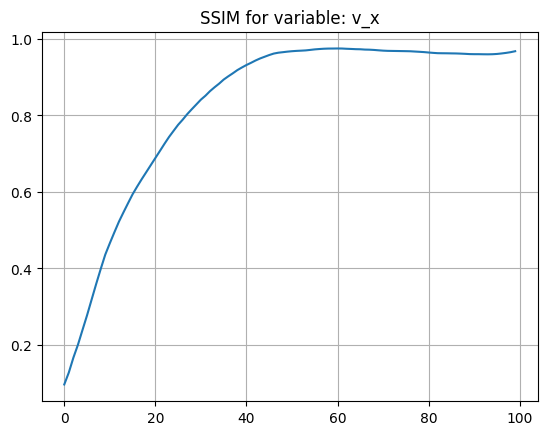

In [8]:
metric = Metric(
    mode=config["metric"]["type"],
    variable_mode= "single", #config["metric"]["variable_mode"]
    variable_name="v_x"
    # variable_name="obstacle_mask"
)
# target_denorm = test_loader.denormalize(ground_truth)
# preds_denorm = test_loader.denormalize(predicted_seq.squeeze())

# # Map both to [0, 1] using dataset min/max
# target_unit = test_loader.to_unit_range(target_denorm)
# preds_unit = test_loader.to_unit_range(preds_denorm)
target_denorm = train_loader.denormalize(ground_truth)
preds_denorm = train_loader.denormalize(predicted_seq.squeeze())

# Map both to [0, 1] using dataset min/max
target_unit = train_loader.to_unit_range(target_denorm)
preds_unit = train_loader.to_unit_range(preds_denorm)
print(input_seq)
print(target_unit)
print(preds_unit)
ipt = TensorDict(
    {
    "reference": target_unit,
    "other": preds_unit, 
    }
)
# ipt = TensorDict(
#     {
#     "reference": input_seq,
#     "other": input_seq, 
#     }
# )
loss = metric(ipt)
print(f"\nLong Rollout {config['metric']['type']} Metric: {loss.mean().item():.4f}")
plt.plot(loss.squeeze().cpu().detach().numpy())
plt.grid()
plt.title(f'{config["metric"]["type"]} for variable: {"v_x"}')
plt.show()

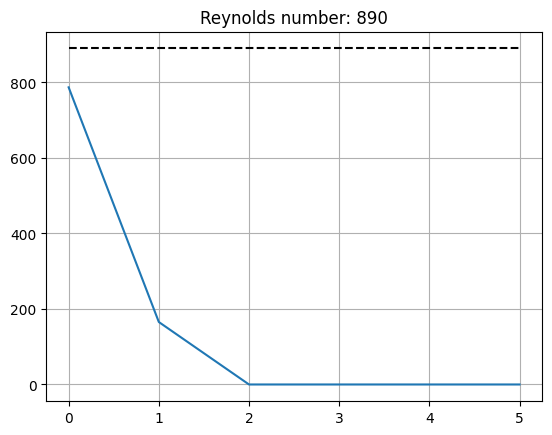

Min/Max p (GT): -9.7993 / 8.9631
Min/Max p (Pred): -20.7428 / 19.7872
Min/Max err p (Pred): -19.8617 / 21.2436


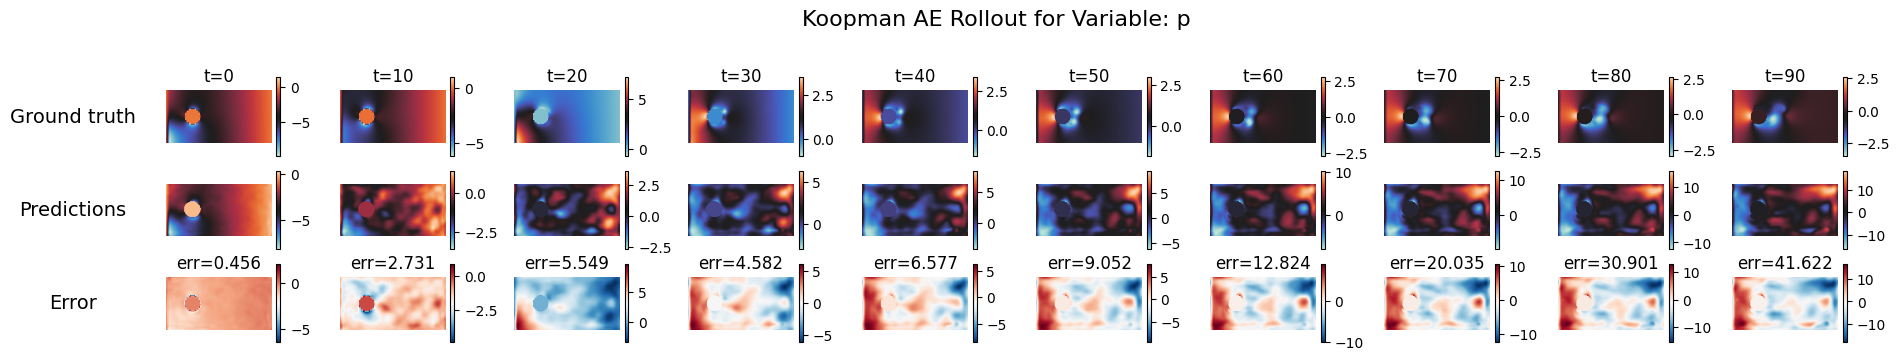

Min/Max v_x (GT): -4.3492 / 2.3046
Min/Max v_x (Pred): -30.0805 / 18.8986
Min/Max err v_x (Pred): -20.8802 / 31.6267


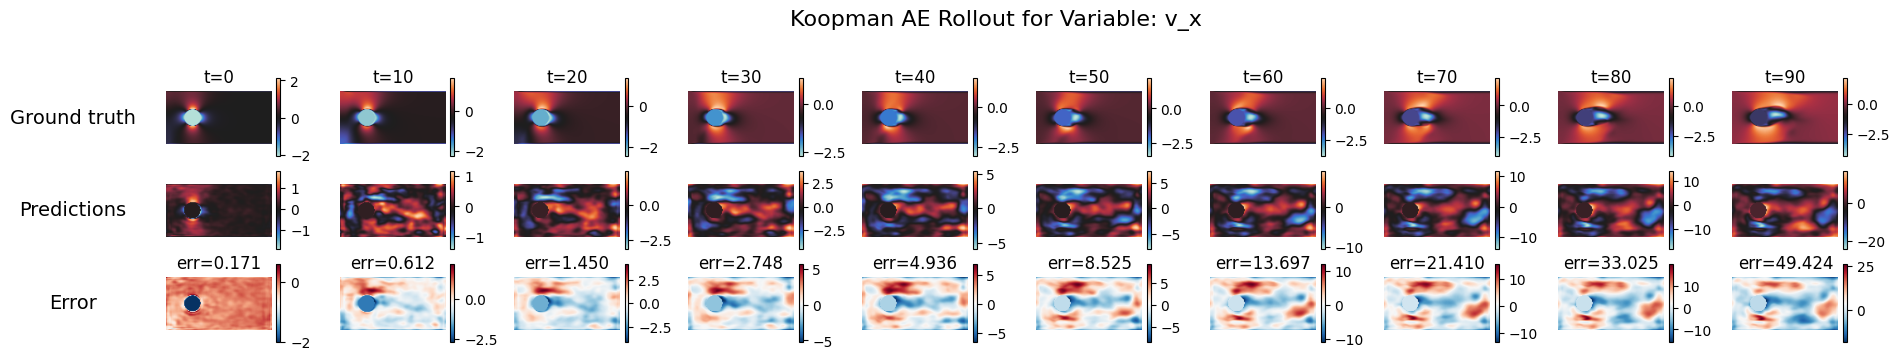

Min/Max v_y (GT): -2.9918 / 2.8813
Min/Max v_y (Pred): -22.2596 / 18.8735
Min/Max err v_y (Pred): -18.8125 / 23.4245


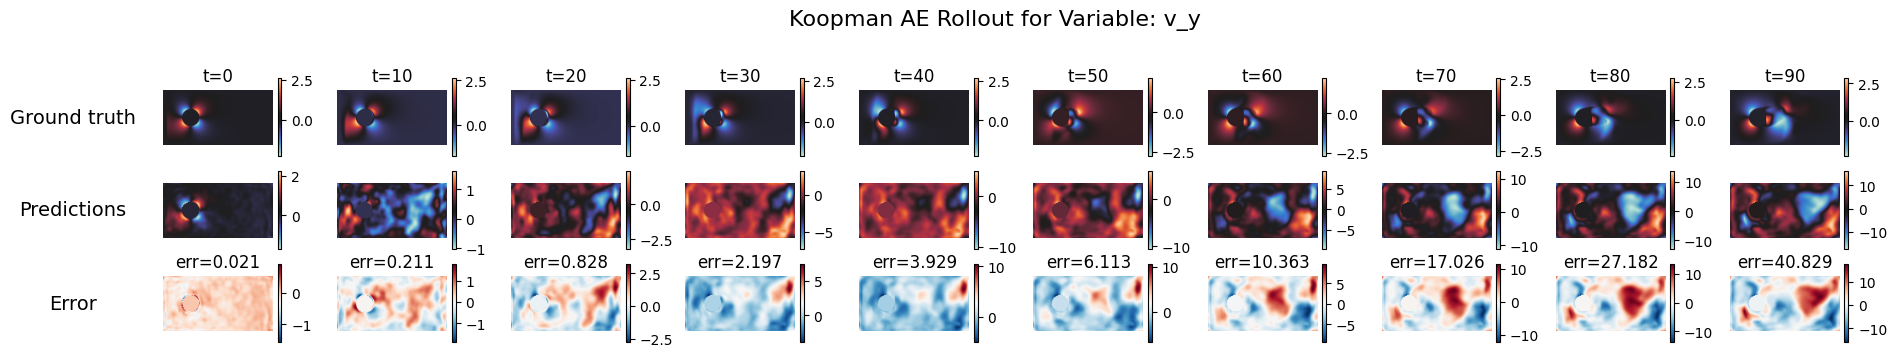

Min/Max vort (GT): -2.3629 / 2.4946
Min/Max vort (Pred): -9.5281 / 12.3478
Min/Max err vort (Pred): -12.4263 / 9.4597


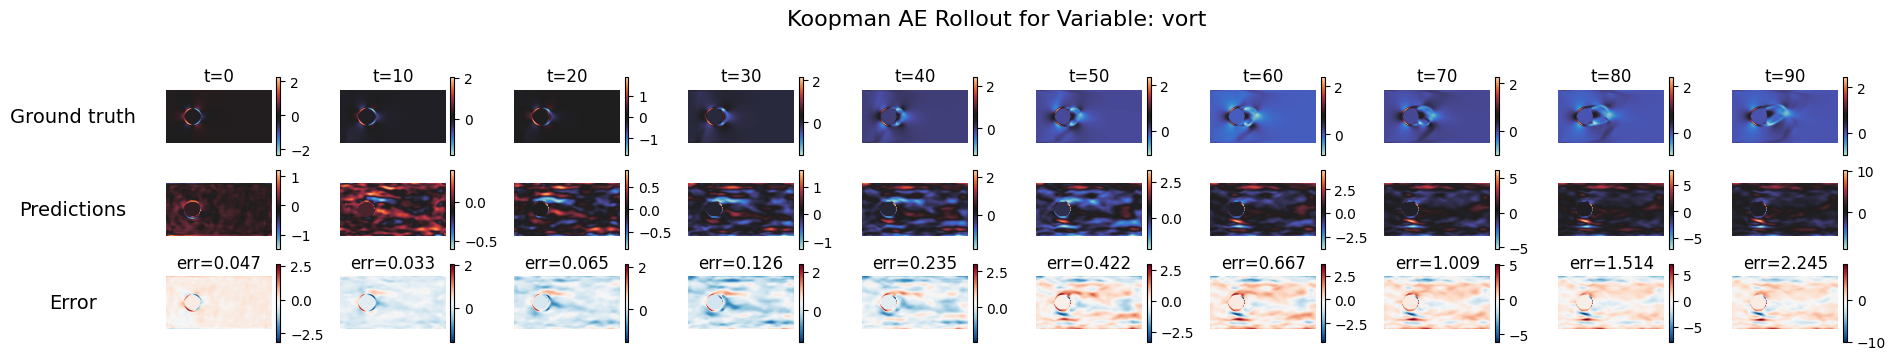

In [9]:
# print(f'true Re: {ground_truth["Re"]}')
# print(f'true Re: {total_predicted_seq.reynolds.squeeze().cpu()}')
SUBSAMPLE = 20
plt.plot(total_predicted_seq.reynolds.squeeze().cpu()[::SUBSAMPLE])
plt.hlines(ground_truth["Re"].squeeze().cpu(), 0, ROLL_OUT_STEPS/SUBSAMPLE, linestyles='--', colors='k')
plt.grid()
plt.title(f'Reynolds number: {int(ground_truth["Re"])}')
plt.show()


plot_rollout(ground_truth.cpu(), predicted_seq.cpu(), variable_name="p", frame_stride=10)
plot_rollout(ground_truth.cpu(), predicted_seq.cpu(), variable_name="v_x", frame_stride=10)
plot_rollout(ground_truth.cpu(), predicted_seq.cpu(), variable_name="v_y", frame_stride=10)

# Compute vorticity from vx and vy
vort_gt = compute_vorticity(ground_truth["v_x"], ground_truth["v_y"])
vort_pred = compute_vorticity(predicted_seq["v_x"], predicted_seq["v_y"])

# Add derived vorticity to the TensorDicts
ground_truth["vort"] = vort_gt
predicted_seq["vort"] = vort_pred

# Plot vorticity
plot_rollout(ground_truth.cpu(), predicted_seq.cpu(), variable_name="vort", frame_stride=10)

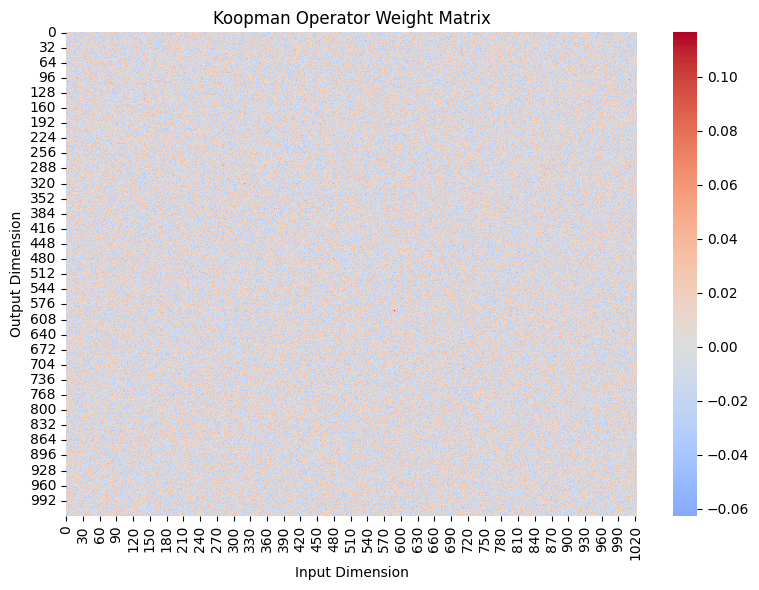

In [10]:
weights = model.koopman_operator.values.detach.cpu()
plt.matshow(weights)

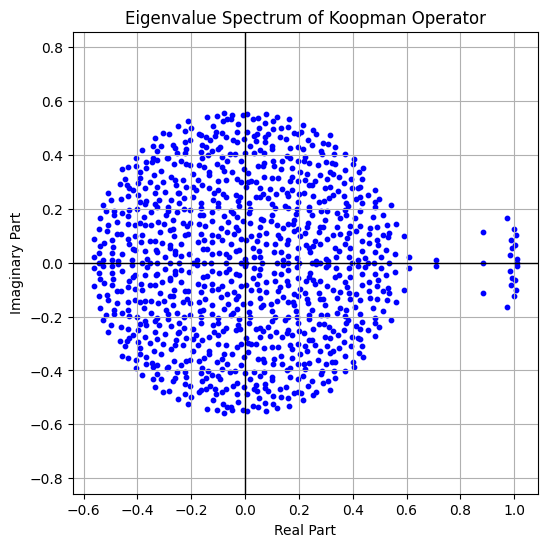

In [11]:
import numpy as np

eigvals = np.linalg.eigvals(weights)

plt.figure(figsize=(6, 6))
plt.scatter(eigvals.real, eigvals.imag, c='blue', s=10)
plt.axhline(0, color='k', lw=1)
plt.axvline(0, color='k', lw=1)
plt.title("Eigenvalue Spectrum of Koopman Operator")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.axis('equal')
plt.show()

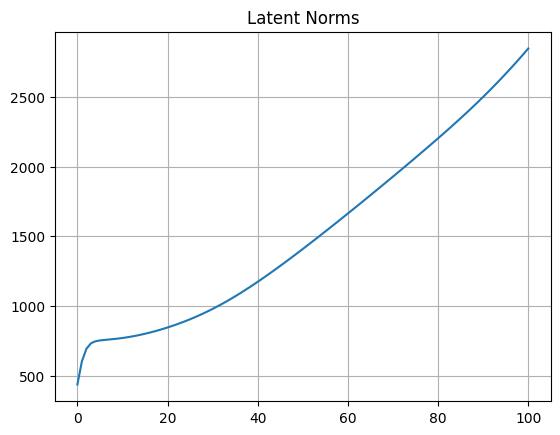

torch.Size([1, 101, 1024])


In [12]:
latents = total_predicted_seq.z_preds.detach().cpu()
latent_norms = torch.norm(latents.squeeze(0)[:], dim =-1)
plt.plot(latent_norms.numpy())
plt.title('Latent Norms')
plt.grid()
plt.show()
print(latents.shape)